# エントロピー最大化と探索の話

**参考**

* [Fast Rates for Maximum Entropy Exploration](https://arxiv.org/abs/2303.08059)

強化学習ではたまに探索を促進するためにエントロピー正則化を導入する話があります。エントロピーってほんとに探索に効くんでしょうか？
エントロピー正則化と探索の理論を見てみましょう。

**表記**

* 今回は無報酬強化学習を考えます
* $\{p_h\}_h$：遷移確率
* $s_1$：初期状態
* 履歴：$I_h = \left(s_1, a_1, u_1, \ldots, s_{h-1}, a_{h-1}, u_{h-1}\right)$
    * $u_h$は$[0, 1]$の範囲の一様分布からの独立なサンプル。つまり、適当なノイズ。
* 行動：$a_h=\psi_h\left(I_h, s_h, u_h\right)$
* 履歴から行動へのマップ関数：$\psi_h:(\mathcal{S} \times \mathcal{A} \times [0,1])^{h-1} \times \mathcal{S} \times[0,1] \rightarrow \mathcal{A}$
* 方策：$\pi = \left(\psi_h\right)_{h \in[H]}$
    * マルコフ方策の場合は$a_h=\psi_h\left(s_h, u_h\right) \sim \pi_h\left(s_h\right)$
* 状態行動訪問分布：$d_h^\pi(s, a)$
* 訪問多面体：全ての訪問分布は次の多面体に属します
$$
\mathcal{K}_p \triangleq\left\{d=\left(d_h\right)_{h \in[H]}: \sum_{a \in \mathcal{A}} d_1(s, a)=\mathbb{1}\left\{s=s_1\right\} \forall s \in \mathcal{S},
\quad \sum_{a \in \mathcal{A}} d_{h+1}(s, a)=\sum_{\left(s^{\prime}, a^{\prime}\right) \in \mathcal{S} \times \mathcal{A}} p_h\left(s \mid s^{\prime}, a^{\prime}\right) d_h\left(s^{\prime}, a^{\prime}\right) \forall s \in \mathcal{S}, \quad \forall h \geq 1\right\}
$$
* 状態遷移の制約を外した訪問多面体：
$$
\mathcal{K} \triangleq\left\{d=\left(d_h\right)_{h \in[H]}: d_h(s, a) \geq 0, \forall(h, s, a) \in[H] \times \mathcal{S} \times \mathcal{A},
\quad \sum_{(s, a) \in \mathcal{S} \times \mathcal{A}} d_h(s, a)=1,\quad \forall h \in[H]\right\} .
$$
* $(s, a)$が$h$ステップで$t$エピソード目までに訪問された回数：$n_h^t(s, a) \triangleq \sum_{i=1}^t \mathbb{1}\left\{\left(s_h^i, a_h^i\right)=(s, a)\right\}$
* $n_h^t(s^\prime \mid s, a) \triangleq \sum_{i=1}^t \mathbb{1}\left\{\left(s_h^i, a_h^i, s_{h+1}^i\right)=\left(s, a, s^{\prime}\right)\right\}$
* 経験分布：$\widehat{p}_h^t\left(s^{\prime} \mid s, a\right)=n_h^t\left(s^{\prime} \mid s, a\right) / n_h^t(s, a)$

以降ではエントロピーを最大化するRLを考えるわけですが、問題設定の中では様々な分布が出てきます。
つまり、最大化するエントロピーの選択肢が色々あるわけですね。いくつか見てみましょう。

## 訪問エントロピーの最大化

まず、次で定義される**訪問エントロピー**を考えてみましょう。

$$
\mathcal{H}_{\mathrm{visit}}\left(d^\pi\right) \triangleq \sum_{h=1}^H \mathcal{H}\left(d_h^\pi\right)
$$

これを最大化する方策を$\pi^{\star, \mathrm{VE}} \in \arg \max _\pi \mathcal{H}_{\text {visit }}\left(d^\pi\right)$とします。
つまり、$\pi^{\star, \mathrm{VE}}$はいろんな状態行動を訪問するわけですね。

---

**訪問エントロピー最大化探索（MVEE）**

MVEEでは、次のように無報酬MDPを探索します。
1. エピソード$t$の最初に、エージェントはエピソード$t-1$までの履歴から方策$\pi^t$を決定します。
2. $\pi_t$に沿って新しい履歴を収集します
3. 停止時刻$\tau$に従ってデータの収集を止めるか判断します。
4. ジェネラルな方策$\hat{\pi}$を出力します。

つまり、MVEEは$\left(\left(\pi^t\right)_{t \in \mathbb{N}}, \tau, \widehat{\pi}\right)$で表記されます。
また、次を満たすアルゴリズム$\left(\left(\pi^t\right)_{t \in \mathbb{N}}, \tau, \widehat{\pi}\right)$をMVEEにおける$(\varepsilon, \delta)$-PACアルゴリズムとよびます。

$$
\mathbb{P}\left(\mathcal{H}_{\text {visit }}\left(d^{\pi^{\star, \mathrm{VE}}}\right)-\mathcal{H}_{\text {visit }}\left(d^{\widehat{\pi}}\right) \leq \varepsilon\right) \geq 1-\delta
$$

実はこのMVEE問題は、次の予測ゲームを解くのと等価になります。

$$
\begin{aligned}
\max _{d \in \mathcal{K}_p} \mathcal{H}_{\mathrm{visit}}(d) & =\max _{d \in \mathcal{K}_p} \min _{\bar{d} \in \mathcal{K}} \sum_{(h, s, a)} d_h(s, a) \log \frac{1}{\bar{d}_h(s, a)} \\
& =\min _{\bar{d} \in \mathcal{K}} \max _{d \in \mathcal{K}_p} \sum_{(h, s, a)} d_h(s, a) \log \frac{1}{\bar{d}_h(s, a)}
\end{aligned}
$$

この2行目はSionのミニマックス定理ってやつですね（TODO:ゲーム理論）。
1行目は

$$
\mathcal{H}_{\mathrm{visit}}(d)=\sum_{h=1}^H \mathcal{H}\left(d_h\right)=\sum_{h=1}^H \mathcal{H}\left(d_h\right)+\mathrm{KL}\left(d_h, d_h\right)=\min _{\bar{d} \in \mathcal{K}} \sum_{h=1}^H\left(\mathcal{H}\left(d_h\right)+\mathrm{KL}\left(d_h, \bar{d}_h\right)\right)=\min _{\bar{d} \in \mathcal{K}} \sum_{(h, s, a)} d_h(s, a) \log \frac{1}{\bar{d}_h(s, a)}
$$

によって簡単に導出されます。

直感的な説明：
* Minプレーヤー側：$\mathrm{KL}\left(d_h, \bar{d}_h\right)$を最小にしようとします。つまり、Maxプレーヤー側の分布を予測しようとします。
* Maxプレーヤー側：Minプレーヤーの予測を崩そうとがんばります。

これを実現するアルゴリズムを見てみましょう。

### MVEEのためのEntGameアルゴリズム　

EntGameアルゴリズムは上記の予測ゲームを実装したものです。

**予測プレーヤー**

Mixture-Forecasterってやつで実現します（[Prediction, Learning, and Games](https://ii.uni.wroc.pl/~lukstafi/pmwiki/uploads/AGT/Prediction_Learning_and_Games.pdf)の９章参照。）
予測プレーヤーは次のように分布を推定します：
* $\bar{d}^t_h(s, a) = \bar{n}_h^{t-1}(s, a) /\left(t+t_0\right)$ 
  * $t_0=S A n_0$とします。ここで、$n_0$は事前カウントです。
  * $\bar{n}_h^t(s, a)=n_h^t(s, a)+n_0$
  * $n_h^t(s, a)$はサンプラープレーヤーが$(s, a)$を訪れた回数です。

**サンプラープレーヤー**

楽観的なbest-responseで実現します。
$$\begin{aligned} \bar{Q}_h^t(s, a) & =\log \frac{1}{\bar{d}_h^{t+1}(s, a)}+\widehat{p}_h^t \bar{V}_{h+1}^t(s, a)+b_h^t(s, a) \\ \bar{V}_h^t(s) & =\operatorname{clip}\left(\max _{a \in \mathcal{A}} \bar{Q}_h^t(s, a), 0, \log \left(t / n_0+S A\right) H\right)\end{aligned}$$

を解いて、その貪欲方策$\pi_h^{t+1}(s) \in \arg \max _{\pi \in \Delta_A} \pi \bar{Q}_h^t(s)$ で実現します。
ここで、

$$
b_h^t(s, a)=\sqrt{\frac{2 H^2 \log ^2(t+S A) \cdot \alpha^{\mathrm{KL}}\left(\delta, n_h^t(s, a)\right)}{n_h^t(s, a)}}
$$

です。疑似アルゴリズムはめんどくさいので論文に任せます。
この予測プレーヤーとサンプラープレーヤーを$T$回繰り返すことを考えます。
このとき、$T=\widetilde{\mathcal{O}}\left(\frac{H^4 S^2 A}{\varepsilon^2}+\frac{H S A}{\varepsilon}\right)$でEntGameが$(\varepsilon, \delta)$-PACであることが証明できます。

TODO: 証明

## 軌跡エントロピーの最大化（MTEE）

**表記**
* 軌跡の集合：$\mathcal{T} \triangleq(\mathcal{S} \times \mathcal{A})^H=\left\{\left(s_1, a_1, \ldots, s_H, a_H\right):\left(s_h, a_h\right) \in \mathcal{S} \times \mathcal{A}, \forall h \in[H]\right\}$
    * 軌跡$m=\left(s_1, a_1, \ldots, s_H, a_H\right)$を方策$\pi$で生成する確率：$q^\pi(m) \triangleq \pi\left(a_1 \mid s_1\right) \prod_{h=2}^H p_{h-1}\left(s_h \mid s_{h-1}, a_{h-1}\right) \pi_h\left(a_h \mid s_h\right)$
    * この表記に乗っ取ると、訪問分布は $d_h^\pi(s, a)=\mathbb{E}_{\left(s_1, a_1, \ldots, s_H, a_H\right) \sim q^\pi}\left[\mathbb{1}\left\{(s, a)=\left(s_h, a_h\right)\right\}\right]$の形で書けることに注意。

先程は訪問分布のエントロピーを最大化しました。今度は軌跡の分布のエントロピーを最大化してみます。つまり、次の**軌跡エントロピー**を考えます：

$$
\mathcal{H}_{\text {traj }}\left(q^\pi\right) \triangleq \mathcal{H}\left(q^\pi\right)=\sum_{m \in \mathcal{T}} q^\pi(m) \log \frac{1}{q^\pi(m)}
$$

$\pi^{\star, \mathrm{TE}} \in \arg \max _\pi \mathcal{H}_{\text {traj }}\left(q^\pi\right)$を軌跡エントロピーを最大化する方策とします。
MVEEの話と同じようにして、アルゴリズム$\left(\left(\pi^t\right)_{t \in \mathbb{N}}, \tau, \widehat{\pi}\right)$は次を満たすときMTEEについて$(\varepsilon, \delta)$-PACと言います。

$$
\mathbb{P}\left(\mathcal{H}_{\text {traj }}\left(q^{\pi^{\star, \mathrm{TE}}}\right)-\mathcal{H}_{\text {traj }}\left(q^{\widehat{\pi}}\right) \leq \varepsilon\right) \leq 1-\delta
$$

MTEEのPAC学習もMVEEと同じように予測ゲームでできますが、もっと直接的な方法があります。


### エントロピー正則化ベルマン作用素

MTEEはMVEEと違い、最適方策がベルマン方程式を解くことで求まります。
次の期待ベルマン方程式と最適ベルマン方程式を考えましょう。

$$
\begin{aligned}
Q_h^\pi(s, a) & =\mathcal{H}\left(p_h(s, a)\right)+p_h V_{h+1}^\pi(s, a), \\
V_h^\pi(s) & =\pi_h Q_h^\pi(s)+\mathcal{H}\left(\pi_h(s)\right), \\
Q_h^{\star}(s, a) & =\mathcal{H}\left(p_h(s, a)\right)+p_h V_{h+1}^{\star}(s, a), \\
V_h^{\star}(s) & =\max _{\pi \in \Delta_A} \pi Q_h^{\star}(s)+\mathcal{H}(\pi),
\end{aligned}
$$

これによって得られる価値関数を表記するために、次の一般化正則化価値関数を考えてみましょう。

$$
V_{\lambda, h}^\pi(s) \triangleq \mathbb{E}_\pi\left[\sum_{h^{\prime}=h}^H r_{h^{\prime}}\left(s_{h^{\prime}}, a_{h^{\prime}}\right)-\lambda \Phi\left(\pi_h\left(s_{h^{\prime}}\right)\right) \mid s_h=s\right]
$$

エントロピーのchain ruleより、$r_h(s, a)=\mathcal{H}(p_h(s, a))$かつ$\lambda=1$かつ$\Phi(\pi)=\mathcal{H}(\pi)$のとき、$V_{\lambda .1}^\pi\left(s_1\right)=\mathcal{H}_{\text {traj }}\left(q^\pi\right)$になります。
上述したベルマン方程式がこの価値関数を求められることは帰納法で考えるとすぐにわかります（論文のAppendix C.1参照）。
このとき、$\mathcal{H}_{\text {traj }}\left(d^\pi\right)=V_1^\pi\left(s_1\right)$かつ$\mathcal{H}_{\text {traj }}\left(d^{\pi^{\star, \mathrm{TE}}}\right)=V_1^{\star}\left(s_1\right)$になります。

つまり、シンプルにベルマン方程式を解けばいいので、MVEEの場合と違って予測プレーヤーがいりません。
具体的にはBest-policy-identificationみたいに解けば良いわけですね。（Best-policy-identificationは[RL_task_agnostic_exploration.ipynb](RL_task_agnostic_exploration.ipynb)を参照。）

**サンプラープレーヤー**

$$
\begin{aligned}
\bar{Q}_h^t(s, a)= & \operatorname{clip}\left(\mathcal{H}\left(\widehat{p}_h(s, a)\right)+b_h^{\mathcal{H}, t}(s, a) +\widehat{p}_h^t \bar{V}_{h+1}^t(s, a)+b_h^{p, t}(s, a), 0, \log (S A) H\right) \\
\bar{V}_h^t(s)= & \max _{\pi \in \Delta_A} \pi \bar{Q}_h^t(s)+\mathcal{H}(\pi), \\
\pi_h^{t+1}(s)= & \underset{\pi \in \Delta_A}{\arg \max } \pi \bar{Q}_h^t(s)+\mathcal{H}(\pi),
\end{aligned}
$$

ここで、ボーナス項は
$$\begin{aligned} b_h^{\mathcal{H}, t}(s, a) & =\sqrt{\frac{2 \beta^{\mathcal{H}}\left(\delta, n_h^t(s, a)\right)}{n_h^t(s, a)}}+\min \left(\frac{\beta^{\mathrm{KL}}\left(\delta, n_h^t(s, a)\right)}{n_h^t(s, a)}, \log (S)\right) \\ b_h^{p, t}(s, a) & =\sqrt{\frac{2 H^2 \log ^2(S A) \beta^{\operatorname{conc}}\left(\delta, n_h^t(s, a)\right)}{n_h^t(s, a)}},\end{aligned}$$
とします。

**停止時刻**

$$
\begin{aligned}
W_h^t(s, a) & =4 H^2 \log (S A) \frac{\beta^{\mathrm{KL}}\left(\delta, n_h^t(s, a)\right)}{n_h^t(s, a)}+\left(1+\frac{1}{H}\right) \widehat{p}_h^t G_{h+1}^t(s, a), \\
G_h^t(s) & =\min \left(\pi_h^{t+1} W_h^t(s)+\frac{1}{2}\left(\bar{V}_h^t(s)-\underline{V}_h^t(s)\right)^2, \log (S A) H\right),
\end{aligned}
$$
として、$G_1^{t-1}\left(s_1\right) \leq \varepsilon$であるときに停止します。（TODO: コレよくわかってないんですよね。Linear MDPのMinimaxなアルゴリズムでも出てきたけど、直感はわかってない。）

疑似アルゴリズムもめんどくさいので論文のAlgorithm2に任せます。

---

このとき、サンプラープレーヤーと停止時刻の定義に従って構築されたアルゴリズム**UCBVI-Ent**は$(\varepsilon, \delta)$-PACになります。また、最適方策は確率$1-\delta$で$\hat{\pi}=\pi^{\tau+1}$になり、
ここで
$$
\tau=\widetilde{\mathcal{O}}\left(\frac{H^6 S^2 A}{\varepsilon}\right)
$$
です。

この停止時刻をよく見ると、$\varepsilon$の次数が１になっていますね。
この点で、エントロピーを導入するとサンプル効率が明らかに向上します。

---

In [11]:
import numpy as np
from functools import partial
from typing import Optional, NamedTuple
import jax.numpy as jnp

def create_rew_P(S: int, A: int):
    """ double_chain MDP (報酬関数, 遷移確率) を作成します
    詳しくは６章参照

    Args:
        S (int): 状態空間のサイズ
        A (int): 行動空間のサイズ

    Returns:
        rew (float): 報酬関数
        P (float): 遷移確率
    """
    assert A == 2

    # 一番右側の状態で1がもらえます
    rew = np.zeros((S, 2))
    rew[-1] = 1.0

    # 1を選ぶと右に, 0を選ぶと左に動きます。0.1の確率で逆方向に動きます。
    P = np.zeros((S, A, S))
    for s in range(S):
        P[s, 0, max(0, s-1)] = 0.9 
        P[s, 0, min(s+1, S-1)] = 0.1 

        P[s, 1, max(0, s-1)] = 0.1 
        P[s, 1, min(s+1, S-1)] = 0.9 
    np.testing.assert_almost_equal(P.sum(axis=-1), 1)

    return jnp.array(rew), jnp.array(P)


class MDP(NamedTuple):
    S_set: jnp.array  # 状態集合
    A_set: jnp.array  # 行動集合
    H: int  # ホライゾン
    rew: jnp.array  # 報酬行列
    P: jnp.array  # 遷移確率行列
    optimal_Q: Optional[jnp.ndarray] = None  # 最適Q値

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_set)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_set)


S = 30
A = 2
S_set = np.arange(S)
A_set = np.arange(A)
H = 20

# Double chain MDP を作ります
rew, P = create_rew_P(S, A)
rew = jnp.repeat(rew[None, :, :], H, axis=0)
P = jnp.repeat(P[None, :, :, :], H, axis=0)
mdp = MDP(S_set, A_set, H, rew, P)

In [12]:
from functools import partial
import jax
import chex


@jax.jit
def compute_greedy_policy(Q: jnp.ndarray):
    """Q関数の貪欲方策を返します

    Args:
        Q (jnp.ndarray): (HxSxA)の行列

    Returns:
        greedy_policy (jnp.ndarray): (HxSxA)の行列
    """
    greedy_policy = jnp.zeros_like(Q)
    H, S, A = Q.shape
    
    def body_fn(i, greedy_policy):
        greedy_policy = greedy_policy.at[i, jnp.arange(S), Q[i].argmax(axis=-1)].set(1)
        return greedy_policy

    greedy_policy = jax.lax.fori_loop(0, H, body_fn, greedy_policy)
    chex.assert_shape(greedy_policy, (H, S, A))
    return greedy_policy


@partial(jax.jit, static_argnames=("H", "S", "A"))
def _compute_optimal_Q(mdp: MDP, H: int, S: int, A: int):
    """ベルマン最適作用素をホライゾン回走らせて最適価値関数を動的計画法で計算します。
    Args:
        mdp (MDP)

    Returns:
        optimal_Q (jnp.ndarray): (HxSxA)の行列
    """

    def backup(i, optimal_Q):
        h = H - i - 1
        max_Q = optimal_Q[h+1].max(axis=1)
        next_v = mdp.P[h] @ max_Q
        chex.assert_shape(next_v, (S, A))
        optimal_Q = optimal_Q.at[h].set(mdp.rew[h] + next_v)
        return optimal_Q
    
    optimal_Q = jnp.zeros((H+1, S, A))
    optimal_Q = jax.lax.fori_loop(0, mdp.H, backup, optimal_Q)
    return optimal_Q[:-1]

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.H, mdp.S, mdp.A)


@jax.jit
def compute_policy_Q(mdp: MDP, policy: jnp.ndarray):
    """ベルマン期待作用素をホライゾン回走らせて価値関数を動的計画法で計算します。
    Args:
        mdp (MDP)
        policy (np.ndarray): (HxSxA)の行列

    Returns:
        optimal_Q (jnp.ndarray): (HxSxA)の行列
    """
    H, S, A = policy.shape

    def backup(i, policy_Q):
        h = H - i - 1
        max_Q = (policy[h+1] * policy_Q[h+1]).sum(axis=1)
        next_v = mdp.P[h] @ max_Q
        chex.assert_shape(next_v, (S, A))
        policy_Q = policy_Q.at[h].set(mdp.rew[h] + next_v)
        return policy_Q
    
    policy_Q = jnp.zeros((H+1, S, A))
    policy_Q = jax.lax.fori_loop(0, mdp.H, backup, policy_Q)
    return policy_Q[:-1]


@jax.jit
def compute_policy_matrix(policy: jnp.ndarray):
    """
    上で定義した方策行列を計算します。方策についての内積が取りたいときに便利です。
    Args:
        policy (jnp.ndarray): (HxSxA)の行列

    Returns:
        policy_matrix (jnp.ndarray): (HxSxSA)の行列
    """
    H, S, A = policy.shape
    PI = policy.reshape(H, 1, S, A)
    PI = jnp.tile(PI, (1, S, 1, 1))
    eyes = jnp.tile(jnp.eye(S).reshape(1, S, S, 1), (H, 1, 1, 1))
    PI = (eyes * PI).reshape(H, S, S*A)
    return PI


@jax.jit
def compute_policy_visit(mdp: MDP, policy: jnp.ndarray, init_dist: jnp.ndarray):
    """MDPと方策について、訪問頻度を動的計画法で計算します。
    Args:
        mdp (MDP)
        policy (jnp.ndarray): (HxSxA)の行列
        init_dist (jnp.ndarray): (S) 初期状態の分布

    Returns:
        visit (jnp.ndarray): (HxSxA)のベクトル
    """
    H, S, A = policy.shape
    Pi = compute_policy_matrix(policy)
    P = mdp.P.reshape(H, S*A, S)

    def body_fn(h, visit):
        next_visit = visit[h] @ P[h] @ Pi[h+1]
        visit = visit.at[h+1].set(next_visit)
        return visit
    
    visit = jnp.zeros((H+1, S*A))
    visit = visit.at[0].set((init_dist @ Pi[0]))
    visit = jax.lax.fori_loop(0, mdp.H, body_fn, visit)
    visit = visit[:-1].reshape(H, S, A)
    return visit


optimal_Q_DP = compute_optimal_Q(mdp)
optimal_policy = compute_greedy_policy(optimal_Q_DP)
mdp = mdp._replace(optimal_Q=optimal_Q_DP)

In [13]:
from jax.random import PRNGKey


@partial(jax.jit, static_argnames=("N",))
def sample_next_state(mdp: MDP, N: int, key: PRNGKey, D: jnp.array):
    """ 遷移行列Pに従って次の状態をN個サンプルします
    Args:
        mdp (MDP)
        N (int): サンプルする個数
        key (PRNGKey)
        D (np.ndarray): 状態行動対の集合 [(h1, s1, a1), (h1, s2, a2), ...]

    Returns:
        new_key (PRNGKey)
        next_s_set (np.ndarray): (len(D) x N) の次状態の集合
        count_HSAS (jnp.ndarray): 各(ステップ, 状態, 行動, 次状態)のペアの出現回数を格納した(H x S x A x S) の行列
    """
    new_key, key = jax.random.split(key)
    keys = jax.random.split(key, num=len(D))

    @jax.vmap
    def choice(key, hsa):
        return jax.random.choice(key, mdp.S_set, shape=(N,), p=P[hsa[0], hsa[1], hsa[2]])

    next_s = choice(keys, D)

    # 集めたサンプルについて、(h, s, a, ns)が何個出たかカウントします。
    H, S, A, S = mdp.P.shape
    count_HSAS = jnp.zeros((H*S*A, S))
    count_D_next_S = jax.vmap(lambda next_s: jnp.bincount(next_s, minlength=S, length=S))(next_s)
    D_ravel = jnp.ravel_multi_index(D.T, (H, S, A), mode="wrap")
    count_HSAS = count_HSAS.at[D_ravel].add(count_D_next_S)
    count_HSAS = count_HSAS.reshape(H, S, A, S)
    return new_key, next_s, count_HSAS


@jax.jit
def collect_samples_eps_greedy(mdp: MDP, key: PRNGKey, q: jnp.array, init_s: int, epsilon: float=0.0):
    """ エピソードの開始から終了まで、MDPとインタラクションしてサンプルをH個集めます。qのε-貪欲方策に従って動きます。
    Args:
        mdp (MDP)
        H (int): ホライゾン
        key (PRNGKey)
        q (jnp.ndarray): 行動価値関数
        init_s (int): 初期状態
        epsilon (float): ε-貪欲のパラメータ

    Returns:
        new_key (PRNGKey)
        sars (jnp.ndarray): (状態, 行動, 報酬, 次状態) x H の軌跡
        count_HSAS (jnp.ndarray): 各(ステップ, 状態, 行動, 次状態)のペアの出現回数を格納した(H x S x A x S) の行列
    """
    H, S, A, S = mdp.P.shape
    chex.assert_shape(q, (H, S, A))

    def body_fn(h, args):
        key, sars, s, count_HSAS = args

        # ε-貪欲方策を実行します
        a = q[h, s].argmax()
        key, key1, key2 = jax.random.split(key, num=3)
        random_a = jax.random.choice(key1, A)
        a = jnp.where(jax.random.uniform(key2) > epsilon, a, random_a)
        
        # 次状態をサンプルします
        key, key1 = jax.random.split(key)
        next_s = jax.random.choice(key1, mdp.S_set, p=P[h, s, a])

        # 集めたデータを記録します
        r = mdp.rew[h, s, a]
        sars = sars.at[h].set((s, a, r, next_s))
        count_HSAS = count_HSAS.at[h, s, a, next_s].add(1)
        return key, sars, next_s, count_HSAS

    sars = jnp.zeros((H, 4))
    count_HSAS = jnp.zeros((H, S, A, S))
    args = key, sars, init_s, count_HSAS
    key, sars, _, count_HSAS = jax.lax.fori_loop(0, H, body_fn, args)
    return key, sars, count_HSAS

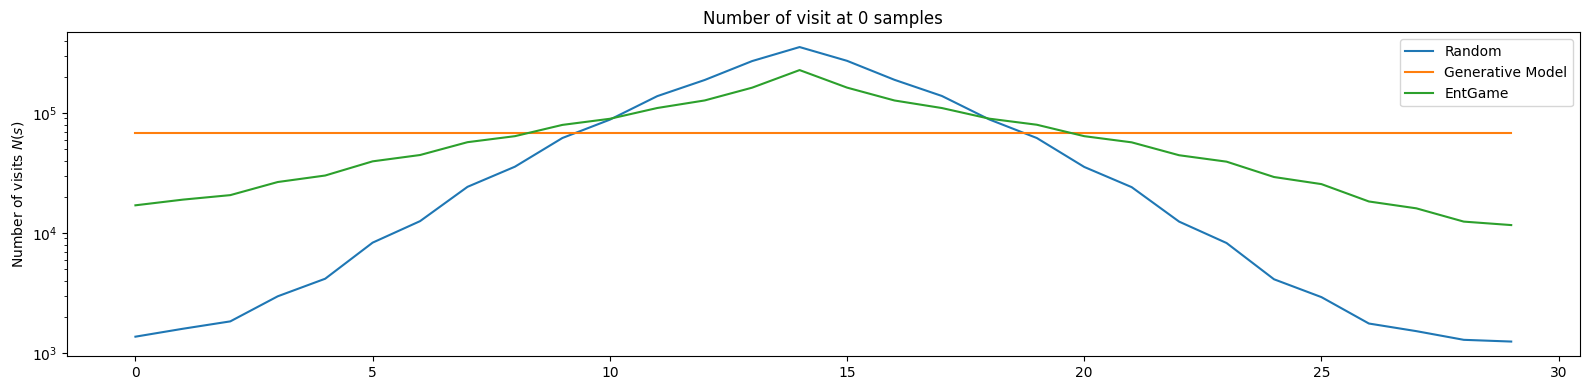

In [17]:
import matplotlib.pyplot as plt
from itertools import product
import chex
from jax.random import PRNGKey


def random_explore(mdp: MDP, num_samples_to_collect: int):
    H, S, A = mdp.H, mdp.S, mdp.A

    key = PRNGKey(0)
    visit_HSAS = np.ones((H, S, A, S))
    uniform_q = jnp.ones((H, S, A))

    num_sample = 0
    init_s = int((mdp.S - 1) / 2)
    num_samples = []
    while num_sample < num_samples_to_collect:
        # データのサンプルをします
        key, _ = jax.random.split(key)
        key, _, count_HSAS = collect_samples_eps_greedy(mdp, key, uniform_q, init_s, epsilon=1.0)
        visit_HSAS = visit_HSAS + count_HSAS

        num_sample += mdp.H
        num_samples.append(num_sample)
    return num_samples, visit_HSAS


def generative_model(mdp: MDP, num_samples_to_collect: int):
    H, S, A = mdp.H, mdp.S, mdp.A

    key = PRNGKey(0)
    visit_HSAS = np.ones((H, S, A, S))
    HSA_set = jnp.array([(h, s, a) for h, s, a in product(range(H), range(S), range(A))])
 
    num_sample = 0
    num_samples = []

    while num_sample < num_samples_to_collect:
        # データのサンプルをします
        key, _ = jax.random.split(key)
        key, _, count_HSAS = sample_next_state(mdp, 1, key, HSA_set)
        visit_HSAS = visit_HSAS + count_HSAS

        num_sample += H * S * A
        num_samples.append(num_sample)
    return num_samples, visit_HSAS


# >>>> EntGame >>>>

@partial(jax.jit, static_argnames=("H", "S", "A"))
def _optimistic_planning(mdp: MDP, t:int, n0, H: int, S: int, A: int):
    maximum = jnp.log(t / (n0 + S * A)) * H

    def backup(i, optimal_Q):
        h = H - i - 1
        max_Q = optimal_Q[h+1].max(axis=1)
        next_v = mdp.P[h] @ max_Q
        target = jnp.minimum(mdp.rew[h] + next_v, maximum)
        target = jnp.maximum(target, 0.0)
        optimal_Q = optimal_Q.at[h].set(target)
        return optimal_Q
    
    optimal_Q = jnp.zeros((H+1, S, A))
    optimal_Q = jax.lax.fori_loop(0, mdp.H, backup, optimal_Q)
    return optimal_Q[:-1]

optimistic_planning = lambda mdp, t, n0: _optimistic_planning(mdp, t, n0, mdp.H, mdp.S, mdp.A)


def EntGame(mdp: MDP, num_samples_to_collect: int):
    n0 = 1
    delta = 1e-3
    S, A, H = mdp.S, mdp.A, mdp.H

    visit_HSAS = np.ones((H, S, A, S)) / S
    t0 = S * A * n0

    key = PRNGKey(0)
    num_sample = 0
    init_s = int((mdp.S - 1) / 2)
    num_samples = []
    T = int(num_samples_to_collect / H)

    for t in range(T):
        t = t + 1
        # 予測プレーヤー
        visit_HSA = visit_HSAS.sum(axis=-1)
        visit_dist = visit_HSA / (t + t0)

        # サンプラープレーヤー
        alpha_KL = jnp.log(2 * S * A * H / delta) + S * jnp.log(jnp.e * (1 + visit_HSA))
        bonus = jnp.sqrt(2 * H ** 2 * jnp.log(t + S*A) ** 2 * alpha_KL / visit_HSA)
        rew = jnp.log(1 / visit_dist + bonus)
        mdp_sampler = mdp._replace(rew=rew)
        P_approx = visit_HSAS / visit_HSAS.sum(axis=-1, keepdims=True)
        mdp_sampler = mdp_sampler._replace(P=P_approx)
        optimistic_Q = optimistic_planning(mdp_sampler, t, n0)

        # データのサンプルと遷移確率の更新をします
        key, _ = jax.random.split(key)
        key, _, count_HSAS = collect_samples_eps_greedy(mdp, key, optimistic_Q, init_s, epsilon=0.0)
        visit_HSAS = visit_HSAS + count_HSAS

        num_samples.append(num_sample)

    return num_samples, visit_HSAS


# plot results
num_samples_to_collect = 100000 * mdp.H

algos = {
    "Random": random_explore, 
    "Generative Model": generative_model,
    "EntGame": EntGame,
}


plt.figure(figsize=(16, 4))
for name, algo in algos.items():
    num_samples, visit_HSAS = algo(mdp, num_samples_to_collect)

    plt.title(f"Number of visit at {num_samples[-1]} samples")
    visit_S = visit_HSAS.sum(axis=(0, 2, 3))
    plt.plot(visit_S, label=name)
    plt.ylabel(r"Number of visits $N(s)$")
    plt.yscale("log")
    plt.legend()

plt.tight_layout()

ちゃんとEntGameで探索できるようになりました、やったね。